In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt

In [ ]:
# 1. Data Ingestion and Preprocessing

all_data = []
for i in range(0, 4):
    file = f"{path}/{file_prefix}{i}.csv"
    data = pd.read_csv(file)
    all_data.append(data)
all_data = pd.concat(all_data, ignore_index=True)


In [ ]:
# 2. Data Preprocessing
all_data['Date'] = pd.to_datetime(all_data['Date'])
cols_to_drop = ['Site Name (of Overall AQI)', 'Site ID (of Overall AQI)', 'Source (of Overall AQI)']
all_data.drop(cols_to_drop, axis=1, inplace=True)
pollutants = ['Ozone', 'PM10', 'PM25']
for col in pollutants:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')
all_data.fillna(method='ffill', inplace=True)
all_data.dropna(inplace=True)
all_data.sort_values(by='Date', inplace=True)


/var/folders/xs/lk0k3mxs3zv60d95xbt2j7tw0000gn/T/ipykernel_77679/3605667553.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)


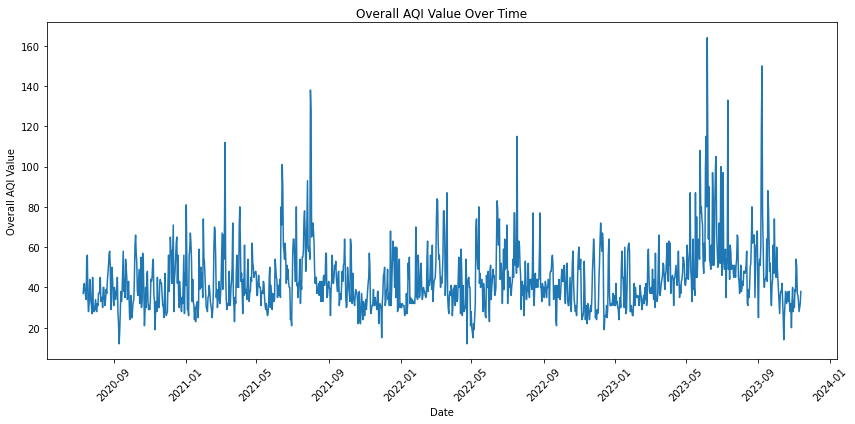

In [ ]:
# Converting 'Date' from string to datetime format
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%m/%d/%Y')

# Sorting the dataframe by date
all_data.sort_values('Date', inplace=True)

# Visualizing the overall AQI values over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_data, x='Date', y='Overall AQI Value')
plt.title('Overall AQI Value Over Time')
plt.xlabel('Date')
plt.ylabel('Overall AQI Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

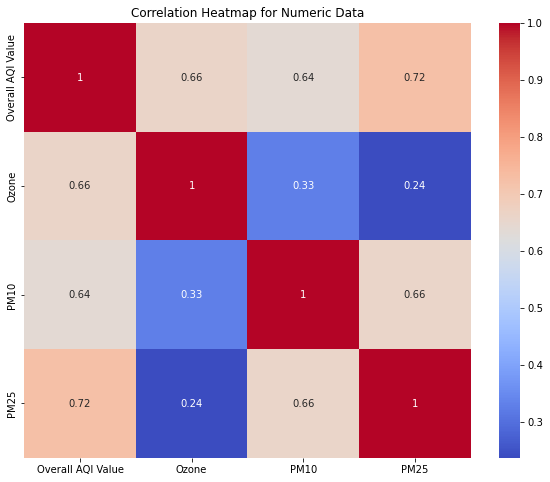

In [ ]:
# Correlation Heatmap

numeric_data = all_data.select_dtypes(include=[np.number])  # Select only numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Numeric Data')
plt.show()


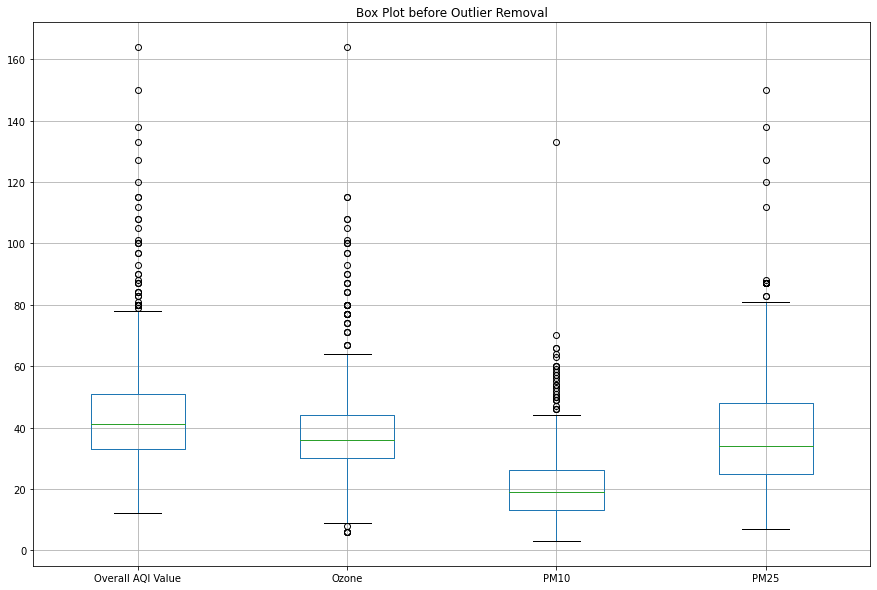

In [ ]:
# Converting 'Date' from string to datetime format
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%m/%d/%Y')

# Sorting the dataframe by date
all_data.sort_values('Date', inplace=True)

# Select numeric columns for outlier detection
numeric_columns = all_data.select_dtypes(include=['float64', 'int64']).columns

# Initial Visualization (before removing outliers)
plt.figure(figsize=(15, 10))
all_data[numeric_columns].boxplot()
plt.title("Box Plot before Outlier Removal")
plt.show()

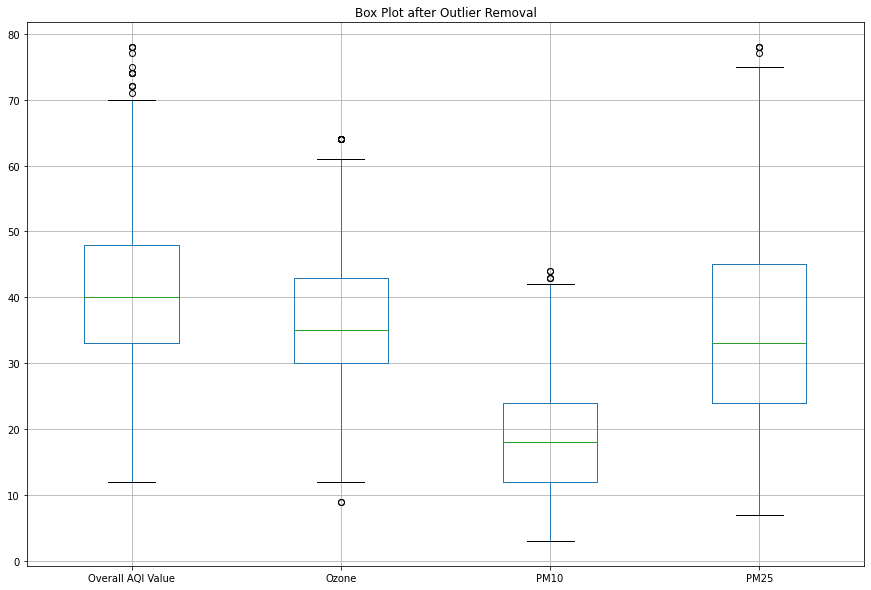

In [ ]:
# Calculate IQR for each numeric column
Q1 = all_data[numeric_columns].quantile(0.25)
Q3 = all_data[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier criteria (1.5 times IQR)
outlier_criteria = (all_data[numeric_columns] < (Q1 - 1.5 * IQR)) | (all_data[numeric_columns] > (Q3 + 1.5 * IQR))

# Filter out outliers
all_data_cleaned = all_data[~(outlier_criteria).any(axis=1)]

# Post-removal Visualization (after removing outliers)
plt.figure(figsize=(15, 10))
all_data_cleaned[numeric_columns].boxplot()
plt.title("Box Plot after Outlier Removal")
plt.show()

In [ ]:
# Train-Test Split (80-20%)
train_size = int(len(all_data) * 0.8)
train, test = all_data.iloc[:train_size], all_data.iloc[train_size:]

In [ ]:
# 3. Data Scaling
numeric_columns = all_data.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[numeric_columns])
test_scaled = scaler.transform(test[numeric_columns])

In [ ]:
# Convert scaled data to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=numeric_columns, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=numeric_columns, index=test.index)

In [ ]:
# 4. Data Preparation for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10

In [ ]:
# Univariate Dataset
X_train_uni, y_train_uni = create_dataset(train_scaled[['Overall AQI Value']], train_scaled['Overall AQI Value'], time_steps)
X_test_uni, y_test_uni = create_dataset(test_scaled[['Overall AQI Value']], test_scaled['Overall AQI Value'], time_steps)

# Multivariate Dataset
X_train_multi, y_train_multi = create_dataset(train_scaled[numeric_columns], train_scaled['Overall AQI Value'], time_steps)
X_test_multi, y_test_multi = create_dataset(test_scaled[numeric_columns], test_scaled['Overall AQI Value'], time_steps)

# Reshape for LSTM input
X_train_uni = X_train_uni.reshape((X_train_uni.shape[0], time_steps, 1))
X_test_uni = X_test_uni.reshape((X_test_uni.shape[0], time_steps, 1))
X_train_multi = X_train_multi.reshape((X_train_multi.shape[0], time_steps, len(numeric_columns)))
X_test_multi = X_test_multi.reshape((X_test_multi.shape[0], time_steps, len(numeric_columns)))


In [ ]:
# 5. LSTM Models
# Univariate LSTM Model
def create_univariate_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Multivariate LSTM Model
def create_multivariate_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Train Univariate Model
univariate_model = create_univariate_lstm_model((X_train_uni.shape[1], 1))
univariate_model.fit(X_train_uni, y_train_uni, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 0.0242 - val_loss: 0.0109
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0076
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0072
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0073
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0078
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0072
Epoch 9/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0069
Epoch 10/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0075
Epoch 11/50
25/25 [

In [ ]:
# Train Multivariate Model
multivariate_model = create_multivariate_lstm_model((X_train_multi.shape[1], len(numeric_columns)))
multivariate_model.fit(X_train_multi, y_train_multi, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 0.0203 - val_loss: 0.0081
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0076
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0072
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0070
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0069
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0067
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 9/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0064
Epoch 10/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0064
Epoch 11/50
25/25 [

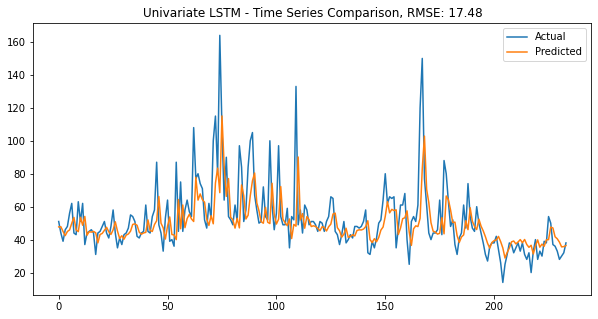

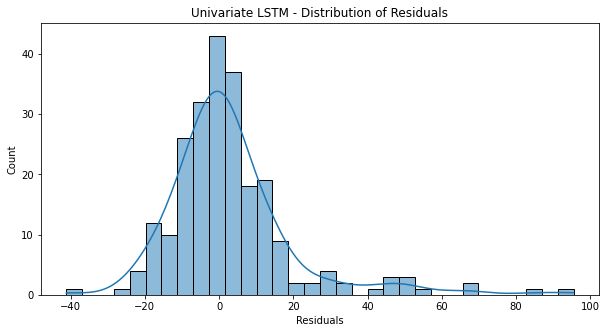

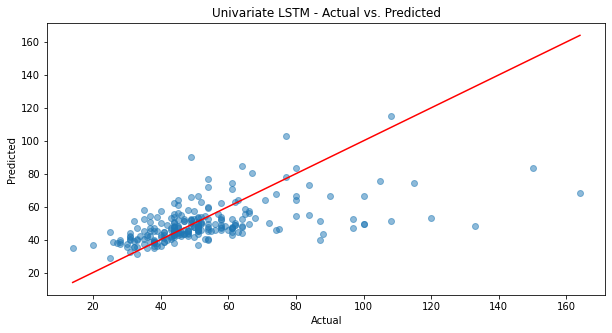

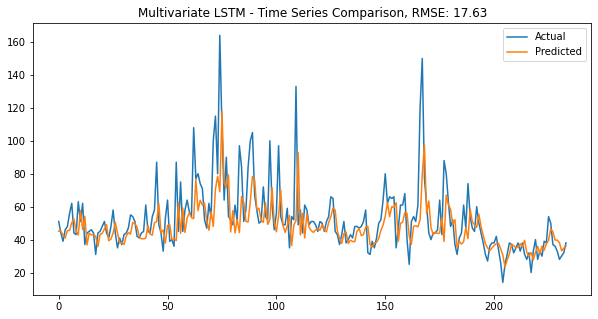

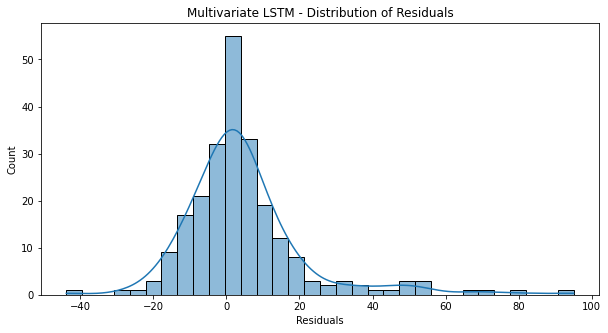

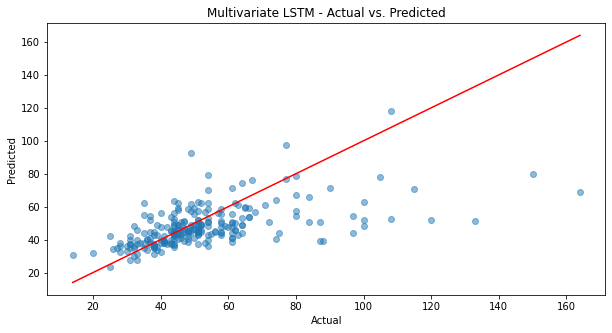

In [ ]:
# 6.Univariate vs Multivariate

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(y_true, y_pred, title):

    rmse = sqrt(mean_squared_error(y_true, y_pred))

    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{title} - Time Series Comparison, RMSE: {rmse:.2f}')
    plt.legend()
    plt.show()

    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True)
    plt.title(f'{title} - Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title} - Actual vs. Predicted')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r')  # Diagonal line
    plt.show()

# Evaluate Models
evaluate_model(y_test_actual[-len(y_pred_uni_actual):], y_pred_uni_actual[:, 0], 'Univariate LSTM')
evaluate_model(y_test_actual[-len(y_pred_multi_actual):], y_pred_multi_actual[:, 0], 'Multivariate LSTM')
